In [1]:
import os, sys, math, time, winsound, random, h5py, time, serial
import numpy as np, pandas as pd, seaborn as sns, tensorflow as tf
# from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import model_from_json
from tensorflow.keras import layers
from scipy import stats
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import clear_output
import my_module as mm
os.makedirs("temp", exist_ok=True)

# パラメータ設定

In [2]:
weight_per_depth = 100 ### depth0.01mの変化で重みが1変動

depth_per_sec = 0.01### 1秒のソレノイド開放でdepthが0.01m変化

# ser = serial.Serial("COM9", 9600)

# 初期化

## NN構築

In [3]:
x_train, y_train, x_test, y_test = mm.make_dataset(1000, 5)

In [4]:
model_initial = keras.models.Sequential([
#   layers.Dense(5, activation='tanh'),
  layers.Dense(2, activation='tanh'),
  layers.Dense(2, activation='tanh'),
  layers.Dense(2, activation='tanh')
])
predictions = model_initial(np.array(x_train)[:1]).numpy()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

3/3 [==============================] - 0s 2ms/step - loss: 0.2944 - accuracy: 0.9118


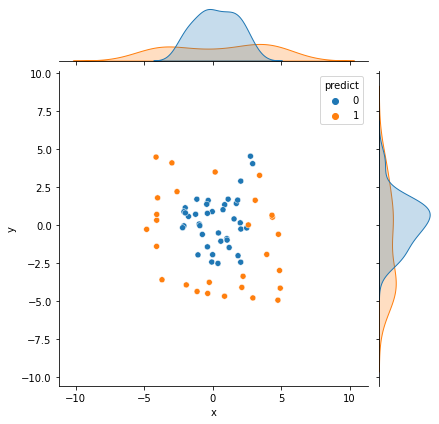

In [5]:
model_initial.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model_initial.fit(x_train, y_train, epochs=10000, verbose=0)
model_initial.evaluate(x_test, y_test)
test_result_2=pd.concat([x_test, y_test, pd.Series(np.argmax(model_initial.predict(x_test, verbose=0), axis = 1), name="predict")], axis=1)
sns.jointplot(x='x', y='y', data=test_result_2, hue="predict", marker="o")

In [6]:
model_initial.save_weights("temp/weight.hdf5")
with open("temp/model.json", 'w') as f:
    f.write(model_initial.to_json())

## Depth読み込み

In [7]:
initial_weight=pd.read_csv("temp/depth_info.csv", header=None)

In [8]:
initial_weight

,0,1,2,3,4
0,1.713,1.692,1.692,1.667,1.704
1,1.667,1.654,1.692,1.687,1.642
2,1.654,1.671,1.679,1.683,1.671
3,0.000,1.683,1.667,0.389,0.000
4,0.000,0.000,0.000,0.260,0.293


In [9]:
def append(name):
    name_list.append(name)

# Loop部

## Depth読み込み

In [10]:
delta=pd.read_csv("temp/depth_info.csv", header=None)-initial_weight
print(delta)
clear_output(wait=True)

     0    1    2    3    4
0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0


## hdf5読み込み

In [11]:
name_list=[]
data={}
with h5py.File("temp/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):        
            data[name]=f[name][()]
data

{'dense/dense/bias:0': array([0.9149146, 0.6097837], dtype=float32),
 'dense/dense/kernel:0': array([[-1.3604003 ,  1.2883662 ],
        [ 0.94684464, -0.34862202],
        [ 1.1191518 , -1.1931894 ],
        [-0.90875906,  0.23707186]], dtype=float32),
 'dense_1/dense_1/bias:0': array([-1.7022043, -1.4635962], dtype=float32),
 'dense_1/dense_1/kernel:0': array([[1.4493887, 1.2335726],
        [1.9090015, 1.6843911]], dtype=float32),
 'dense_2/dense_2/bias:0': array([-1.2151836,  1.2146573], dtype=float32),
 'dense_2/dense_2/kernel:0': array([[ 30.042713, -30.068743],
        [ 26.985113, -26.943905]], dtype=float32)}

## 重み修正と反映

In [12]:
weight_per_depth

100

In [13]:
# 重み修正 係数weight_per_depth*deltaをweightへ足したり引いたり
weight_values=[]
for x in range(len(delta)):
    for y in range(len(delta.columns)):
        weight_values.append(delta.iloc[x,y]*weight_per_depth)

In [14]:
count=0
for name in data:
    print(len(data[name]), data[name])
    if len(data[name].shape)==1: # bias
        for x in range(data[name].shape[0]):
            data[name][x]=weight_values[count]
            count+=1
    elif len(data[name].shape)==2: # weight
        for x in range(data[name].shape[0]):
            for y in range(data[name].shape[1]):
                data[name][x][y]=weight_values[count]
                count+=1
print(count)

2 [0.9149146 0.6097837]
4 [[-1.3604003   1.2883662 ]
 [ 0.94684464 -0.34862202]
 [ 1.1191518  -1.1931894 ]
 [-0.90875906  0.23707186]]
2 [-1.7022043 -1.4635962]
2 [[1.4493887 1.2335726]
 [1.9090015 1.6843911]]
2 [-1.2151836  1.2146573]
2 [[ 30.042713 -30.068743]
 [ 26.985113 -26.943905]]
22


In [15]:
for name in data:
    print(len(data[name]), data[name])

2 [0. 0.]
4 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
2 [0. 0.]
2 [[0. 0.]
 [0. 0.]]
2 [0. 0.]
2 [[0. 0.]
 [0. 0.]]


## 修正重みをhdf5へ反映

In [16]:
name_list=[]
with h5py.File("temp/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):
            if len(data[name].shape)==1: # bias
                for x in range(data[name].shape[0]):
                    data[name][x]=0
            elif len(data[name].shape)==2: # weight
                for x in range(data[name].shape[0]):
                    for y in range(data[name].shape[1]):
                        data[name][x][y]=0
            else: #?
                raise UserWarning("length>3")
            f[name][()]=data[name]
            print(f[name][()])

[0. 0.]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[0. 0.]
[[0. 0.]
 [0. 0.]]
[0. 0.]
[[0. 0.]
 [0. 0.]]


## モデル再コンパイル&予測スコア出力

3/3 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5000


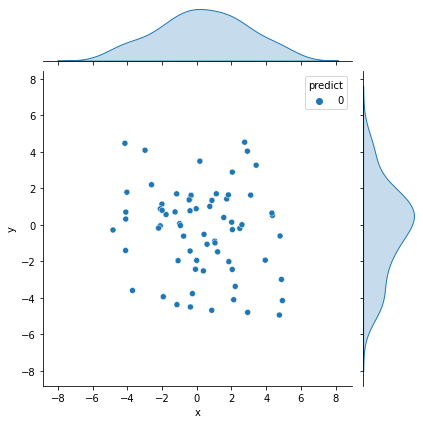

In [17]:
model=tf.keras.models.model_from_json(open("temp/model.json", "r").read())
model.load_weights("temp/weight.hdf5")
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model.evaluate(x_test, y_test)
test_result=pd.concat([x_test, y_test, pd.Series(np.argmax(model.predict(x_test, verbose=0), axis = 1), name="predict")], axis=1)
sns.jointplot(x='x', y='y', data=test_result, hue="predict", marker="o")

## ちょっと学習

## Arduinoへソレノイド操作の信号送信

### 学習前の重み情報を取得

In [18]:
weight_old=[]
for name in data:
#     print(len(data[name]), data[name])
    if len(data[name].shape)==1: # bias
        for x in range(data[name].shape[0]):
            weight_old.append(data[name][x])
    elif len(data[name].shape)==2: # weight
        for x in range(data[name].shape[0]):
            for y in range(data[name].shape[1]):
                weight_old.append(data[name][x][y])
print(weight_old)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### 学習後の重み情報を取得

In [19]:
model.save_weights("temp/weight.hdf5")

In [20]:
name_list=[]
data={}
with h5py.File("temp/weight.hdf5",'r+') as f:
    f.visit(append)
    for name in name_list:
        if isinstance(f[name], h5py.Dataset):        
            data[name]=f[name][()]

In [21]:
weight_fixed=[]
for name in data:
    if len(data[name].shape)==1: # bias
        for x in range(data[name].shape[0]):
            weight_fixed.append(data[name][x])
    elif len(data[name].shape)==2: # weight
        for x in range(data[name].shape[0]):
            for y in range(data[name].shape[1]):
                weight_fixed.append(data[name][x][y])
print(weight_fixed)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [22]:
order=[]
for i in range(len(weight_old)):
    order.append((weight_fixed[i]-weight_old[i])/weight_per_depth/depth_per_sec)

### シリアル通信

In [23]:
ser.write(order)

NameError: name 'ser' is not defined

In [ ]:
time.sleep(1) ## ? 